In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

from src.pods.Pods import train
from src.hds.Hds import train
from src.env.Pendulum import InvertedPendulum
import pickle


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = InvertedPendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

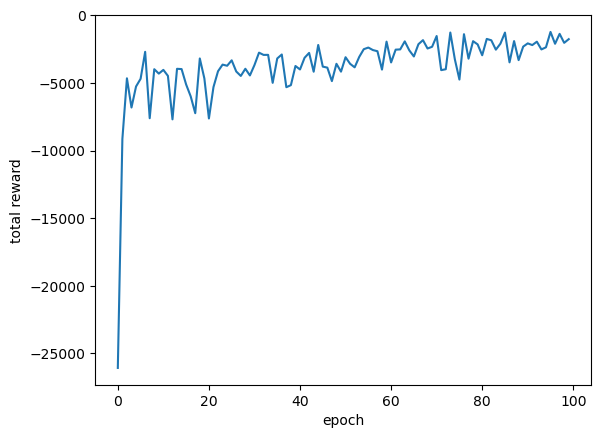

big epoch: 99 small epoch: 0 Loss 0.37215656
big epoch: 99 small epoch: 1 Loss 0.22507878
big epoch: 99 small epoch: 2 Loss 0.33382457
big epoch: 99 small epoch: 3 Loss 0.39038035
big epoch: 99 small epoch: 4 Loss 0.23765215
big epoch: 99 small epoch: 5 Loss 0.3651091
big epoch: 99 small epoch: 6 Loss 0.3496688
big epoch: 99 small epoch: 7 Loss 0.41404787
big epoch: 99 small epoch: 8 Loss 0.4099015
big epoch: 99 small epoch: 9 Loss 0.4400356
big epoch: 99 small epoch: 10 Loss 0.432527
big epoch: 99 small epoch: 11 Loss 0.22579373
big epoch: 99 small epoch: 12 Loss 0.45197713
big epoch: 99 small epoch: 13 Loss 0.41013676
big epoch: 99 small epoch: 14 Loss 0.3776242
big epoch: 99 small epoch: 15 Loss 0.3196554
big epoch: 99 small epoch: 16 Loss 0.40674397
big epoch: 99 small epoch: 17 Loss 0.2764267
big epoch: 99 small epoch: 18 Loss 0.397247
big epoch: 99 small epoch: 19 Loss 0.3728074


In [4]:

def progress_f(x_data,y_data,epoch,reward):
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train(env,trajectory_length=30,num_samples=8,epochs=100,alpha_a=1e-5,progress_fn=progress_f)

In [5]:
f = f = open("traj.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act = inference_fn(state.obs)
  state = env.step(state, act)
print(rollout,file=f)

In [6]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)